In [2]:
# conda install -c conda-forge pyspark 
# import findspark
# findspark.init()
from sedona.spark import SedonaContext
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType, LongType, ArrayType
from pyspark.sql import Row
from pprint import pprint
from time import sleep
from pyspark.sql.window import Window
import pandas as pd
# import Transformer
import geopandas as gpd
from pyproj import Transformer
pd.set_option('display.max_columns', None)
import os
import re
from sklearn.cluster import DBSCAN
import geopandas as gpd
from pyspark.sql.functions import col, udf
!pip install clickhouse_connect
!pip install pyxlsb
!pip install osmium shapely
!pip install python-dotenv
import clickhouse_connect
from pyspark.sql.functions import split, col
from pyspark.sql.functions import sum, avg, count
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import os
from dotenv import load_dotenv
from pyspark.sql import Window
from pyspark.sql.functions import row_number, rank, dense_rank
from pyspark.sql.functions import col, split, when, last, monotonically_increasing_id, expr 
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, StringType
import pyspark.sql.functions as F
import builtins 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl

load_dotenv('../.env')

CH_IP = os.getenv('CH_IP')
CLICKHOUSE_USER = os.getenv('CLICKHOUSE_USER')
CLICKHOUSE_PASSWORD = os.getenv('CLICKHOUSE_PASSWORD')

client = clickhouse_connect.get_client(host=CH_IP, port=8123, username=CLICKHOUSE_USER, password=CLICKHOUSE_PASSWORD)

packages = [
        "com.clickhouse.spark:clickhouse-spark-runtime-3.5_2.12:0.8.0"
        ,"com.clickhouse:clickhouse-jdbc:0.7.0"
        ,"com.clickhouse:clickhouse-client:0.7.0"
        ,"com.clickhouse:clickhouse-http-client:0.7.0"
        ,"org.apache.httpcomponents.client5:httpclient5:5.3.1"
        ,'org.apache.sedona:sedona-spark-3.5_2.12:1.7.0'
        ,'org.datasyslab:geotools-wrapper:1.7.0-28.5'
        ,'uk.co.gresearch.spark:spark-extension_2.12:2.11.0-3.4'
    ]

ram = 10
cpu = 4*3

spark = (
    SparkSession.builder
        .appName('appName')
        .master(f"spark://127.0.0.1:7077")
        .config("spark.jars.packages", ','.join(packages))
        .config('spark.jars.repositories', 'https://artifacts.unidata.ucar.edu/repository/unidata-all')
        .config("spark.sql.catalog.clickhouse", "com.clickhouse.spark.ClickHouseCatalog")
        .config("spark.sql.catalog.clickhouse.host", f"{CH_IP}")
        .config("spark.sql.catalog.clickhouse.protocol", "http")
        .config("spark.sql.catalog.clickhouse.http_port", "8123")
        .config("spark.sql.catalog.clickhouse.user", f"{CLICKHOUSE_USER}")
        .config("spark.sql.catalog.clickhouse.password", f"{CLICKHOUSE_PASSWORD}")
        .config("spark.sql.catalog.clickhouse.database", "default")
        .config("spark.executor.memory", f"{ram}g")
        .config("spark.driver.memory", f"{ram}g")
        .config("spark.driver.maxResultSize", f"{ram}g")
        .config("spark.executor.memoryOverhead", f"{ram}g")
        .config("spark.clickhouse.write.format", "json")

        .getOrCreate()
    )

#sedona = SedonaContext.create(spark) 
SedonaRegistrator.registerAll(spark)
spark.sql("use clickhouse")
base = '/home/evharthman'
path_data = f"{base}/data"


https://artifacts.unidata.ucar.edu/repository/unidata-all added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/evharthman/.ivy2/cache
The jars for the packages stored in: /home/evharthman/.ivy2/jars
com.clickhouse.spark#clickhouse-spark-runtime-3.5_2.12 added as a dependency
com.clickhouse#clickhouse-jdbc added as a dependency
com.clickhouse#clickhouse-client added as a dependency
com.clickhouse#clickhouse-http-client added as a dependency
org.apache.httpcomponents.client5#httpclient5 added as a dependency
org.apache.sedona#sedona-spark-3.5_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
uk.co.gresearch.spark#spark-extension_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9a79e939-1e68-4c24-8bf7-345e6c6d5c47;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/evharthman/miniconda3/envs/spark/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.clickhouse.spark#clickhouse-spark-runtime-3.5_2.12;0.8.0 in central
	found com.clickhouse#clickhouse-jdbc;0.7.0 in central
	found com.clickhouse#clickhouse-client;0.7.0 in central
	found com.clickhouse#clickhouse-data;0.7.0 in central
	found com.clickhouse#clickhouse-http-client;0.7.0 in central
	found org.apache.httpcomponents.client5#httpclient5;5.3.1 in central
	found org.apache.httpcomponents.core5#httpcore5;5.2.4 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.2.4 in central
	found org.slf4j#slf4j-api;1.7.36 in central
	found org.apache.sedona#sedona-spark-3.5_2.12;1.7.0 in central
	found org.apache.sedona#sedona-common;1.7.0 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found org.locationtech.jts#jts-core;1.20.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.locationtech.spatial4j#spatial4j;0.8 in central
	found com.google.geometry#s2-geometry;2.0.0 in central
	found com.google.guava#guava;25.1-jre in centr

In [3]:
df = pl.from_pandas(client.query_df("SELECT * FROM crime_data.crime_merge"))
df

ID,Date,PD_CD,PD_DESC,KY_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,Lon_Lat,geom,District,intersects,Case Number,Block,IUCR,Primary Type,Location Description,Arrest,Domestic,Beat,Ward,Community Area,FBI Code,Year,Updated On,Location,DIST_LABEL,DIST_NUM
i32,str,i32,str,i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,str,i64,bool,str,str,str,str,str,bool,bool,i32,i32,i32,str,i32,str,str,str,i32
9000824,"""02/06/2013 04:10:00 PM""",0,"""""",0,"""AGGRAVATED:KNIFE/CUTTING INSTR""","""""","""""","""""",0,0,"""""","""""","""""",1.184601e6,1.85259e6,41.75067,-87.599103,"""""","""EgAAAAEAAACAi5KzV+ZVwCH2efQV4E…",6,true,"""HW147492""","""079XX S DOBSON AVE""","""0520""","""ASSAULT""","""RESIDENCE""",false,true,624,8,44,"""04A""",2013,"""02/10/2018 03:50:01 PM""","""(41.750670013, -87.599102872)""","""6TH""",6
9000826,"""02/07/2013 10:12:00 AM""",0,"""""",0,"""RETAIL THEFT""","""""","""""","""""",0,0,"""""","""""","""""",1.177338e6,1.906181e6,41.897895,-87.624097,"""""","""EgAAAAEAAABCAeMy8edVwLb/QDru8k…",18,true,"""HW147528""","""008XX N MICHIGAN AVE""","""0860""","""THEFT""","""DEPARTMENT STORE""",false,false,1833,42,8,"""06""",2013,"""02/10/2018 03:50:01 PM""","""(41.897895128, -87.624096605)""","""18TH""",18
9000832,"""01/30/2013 10:30:00 AM""",0,"""""",0,"""MANU/DELIVER:CRACK""","""""","""""","""""",0,0,"""""","""""","""""",1.151466e6,1.893604e6,41.86393,-87.719452,"""""","""EgAAAAEAAAAeVnuCC+5VwDHuukKV7k…",10,true,"""HW137403""","""013XX S INDEPENDENCE BLVD""","""2017""","""NARCOTICS""","""OTHER""",true,false,1011,24,29,"""18""",2013,"""02/10/2018 03:50:01 PM""","""(41.863930074, -87.719452496)""","""10TH""",10
9000833,"""02/07/2013 02:05:00 PM""",0,"""""",0,"""TO LAND""","""""","""""","""""",0,0,"""""","""""","""""",1.142285e6,1.899542e6,41.8804,-87.753009,"""""","""EgAAAAEAAACSL8lKMfBVwP8Dw/Gw8E…",15,true,"""HW147687""","""051XX W MADISON ST""","""1330""","""CRIMINAL TRESPASS""","""PARKING LOT/GARAGE(NON.RESID.)""",false,false,1533,28,25,"""26""",2013,"""02/10/2018 03:50:01 PM""","""(41.880399914, -87.753008553)""","""15TH""",15
9000834,"""02/07/2013 12:50:00 PM""",0,"""""",0,"""RECKLESS CONDUCT""","""""","""""","""""",0,0,"""""","""""","""""",1.155402e6,1.905875e6,41.897525,-87.704674,"""""","""EgAAAAEAAAA8cy1fGe1VwBWcmRfi8k…",12,true,"""HW147639""","""031XX W GRAND AVE""","""0470""","""PUBLIC PEACE VIOLATION""","""SCHOOL, PUBLIC, BUILDING""",false,false,1211,26,23,"""24""",2013,"""02/10/2018 03:50:01 PM""","""(41.897524786, -87.704673571)""","""12TH""",12
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,"""09/07/2009""",115,"""RECKLESS ENDANGERMENT 2""",355,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""POINT (-74.14400559599994 40.6…","""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,true,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
65529798,"""09/07/2009""",905,"""INTOXICATED DRIVING,ALCOHOL""",347,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""POINT (-74.18884349499997 40.5…","""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,true,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
65529799,"""09/07/2009""",106,"""ASSAULT 2,1,PEACE OFFICER""",106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""POINT (-74.06366748399995 40.6…","""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,true,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0


In [32]:
type(df)

polars.dataframe.frame.DataFrame

In [4]:
df.columns = [col.strip() for col in df.columns ]
df = df.drop(['intersects'])
df

ID,Date,PD_CD,PD_DESC,KY_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,Lon_Lat,geom,District,Case Number,Block,IUCR,Primary Type,Location Description,Arrest,Domestic,Beat,Ward,Community Area,FBI Code,Year,Updated On,Location,DIST_LABEL,DIST_NUM
i32,str,i32,str,i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,str,i64,str,str,str,str,str,bool,bool,i32,i32,i32,str,i32,str,str,str,i32
9000824,"""02/06/2013 04:10:00 PM""",0,"""""",0,"""AGGRAVATED:KNIFE/CUTTING INSTR""","""""","""""","""""",0,0,"""""","""""","""""",1.184601e6,1.85259e6,41.75067,-87.599103,"""""","""EgAAAAEAAACAi5KzV+ZVwCH2efQV4E…",6,"""HW147492""","""079XX S DOBSON AVE""","""0520""","""ASSAULT""","""RESIDENCE""",false,true,624,8,44,"""04A""",2013,"""02/10/2018 03:50:01 PM""","""(41.750670013, -87.599102872)""","""6TH""",6
9000826,"""02/07/2013 10:12:00 AM""",0,"""""",0,"""RETAIL THEFT""","""""","""""","""""",0,0,"""""","""""","""""",1.177338e6,1.906181e6,41.897895,-87.624097,"""""","""EgAAAAEAAABCAeMy8edVwLb/QDru8k…",18,"""HW147528""","""008XX N MICHIGAN AVE""","""0860""","""THEFT""","""DEPARTMENT STORE""",false,false,1833,42,8,"""06""",2013,"""02/10/2018 03:50:01 PM""","""(41.897895128, -87.624096605)""","""18TH""",18
9000832,"""01/30/2013 10:30:00 AM""",0,"""""",0,"""MANU/DELIVER:CRACK""","""""","""""","""""",0,0,"""""","""""","""""",1.151466e6,1.893604e6,41.86393,-87.719452,"""""","""EgAAAAEAAAAeVnuCC+5VwDHuukKV7k…",10,"""HW137403""","""013XX S INDEPENDENCE BLVD""","""2017""","""NARCOTICS""","""OTHER""",true,false,1011,24,29,"""18""",2013,"""02/10/2018 03:50:01 PM""","""(41.863930074, -87.719452496)""","""10TH""",10
9000833,"""02/07/2013 02:05:00 PM""",0,"""""",0,"""TO LAND""","""""","""""","""""",0,0,"""""","""""","""""",1.142285e6,1.899542e6,41.8804,-87.753009,"""""","""EgAAAAEAAACSL8lKMfBVwP8Dw/Gw8E…",15,"""HW147687""","""051XX W MADISON ST""","""1330""","""CRIMINAL TRESPASS""","""PARKING LOT/GARAGE(NON.RESID.)""",false,false,1533,28,25,"""26""",2013,"""02/10/2018 03:50:01 PM""","""(41.880399914, -87.753008553)""","""15TH""",15
9000834,"""02/07/2013 12:50:00 PM""",0,"""""",0,"""RECKLESS CONDUCT""","""""","""""","""""",0,0,"""""","""""","""""",1.155402e6,1.905875e6,41.897525,-87.704674,"""""","""EgAAAAEAAAA8cy1fGe1VwBWcmRfi8k…",12,"""HW147639""","""031XX W GRAND AVE""","""0470""","""PUBLIC PEACE VIOLATION""","""SCHOOL, PUBLIC, BUILDING""",false,false,1211,26,23,"""24""",2013,"""02/10/2018 03:50:01 PM""","""(41.897524786, -87.704673571)""","""12TH""",12
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,"""09/07/2009""",115,"""RECKLESS ENDANGERMENT 2""",355,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""POINT (-74.14400559599994 40.6…","""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
65529798,"""09/07/2009""",905,"""INTOXICATED DRIVING,ALCOHOL""",347,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""POINT (-74.18884349499997 40.5…","""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
65529799,"""09/07/2009""",106,"""ASSAULT 2,1,PEACE OFFICER""",106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""POINT (-74.06366748399995 40.6…","""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0


In [19]:
df.with_columns(pl.col("IUCR").str.to_integer(base=32, strict=False).alias("IUCR"))

ID,Date,PD_CD,PD_DESC,KY_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,Lon_Lat,geom,District,intersects,Case Number,Block,IUCR,Primary Type,Location Description,Arrest,Domestic,Beat,Ward,Community Area,FBI Code,Year,Updated On,Location,DIST_LABEL,DIST_NUM
i32,str,i32,str,i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,str,i64,bool,str,str,i64,str,str,bool,bool,i32,i32,i32,str,i32,str,str,str,i32
109557691,"""04/14/2014""",848,"""NY STATE LAWS,UNCLASSIFIED MIS…",364,"""OTHER STATE LAWS (NON PENAL LA…","""LOC00000UM""","""M""","""M""",22,0,"""25-44""","""M""","""WHITE""",993700.0,224344.0,40.782452,-73.965878,"""POINT (-73.96587826899997 40.7…","""EgAAAAEAAABoURbz0H1SwICy7mEnZE…",164,true,"""""","""""",null,"""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
109557692,"""04/14/2014""",849,"""NY STATE LAWS,UNCLASSIFIED VIO…",677,"""OTHER STATE LAWS""","""LOC000000V""","""V""","""Q""",110,0,"""25-44""","""M""","""WHITE HISPANIC""",1.021552e6,212402.0,40.749601,-73.865373,"""POINT (-73.86537333399998 40.7…","""EgAAAAEAAAARF9ZGYndSwE8mB+nyX0…",403,true,"""""","""""",null,"""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
109557693,"""04/13/2014""",922,"""TRAFFIC,UNCLASSIFIED MISDEMEAN""",348,"""VEHICLE AND TRAFFIC LAWS""","""VTL0511001""","""M""","""B""",40,0,"""25-44""","""M""","""BLACK""",1.009419e6,235573.0,40.813242,-73.909076,"""POINT (-73.90907618199996 40.8…","""EgAAAAEAAADL0N1NLnpSwK87IE0YaE…",201,true,"""""","""""",null,"""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
109557694,"""04/14/2014""",922,"""TRAFFIC,UNCLASSIFIED MISDEMEAN""",348,"""VEHICLE AND TRAFFIC LAWS""","""VTL0511001""","""M""","""B""",43,0,"""25-44""","""M""","""BLACK""",1.018703e6,241414.0,40.829242,-73.875507,"""POINT (-73.87550694899994 40.8…","""EgAAAAEAAAAIWExOCHhSwGB0gpskak…",209,true,"""""","""""",null,"""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
109557695,"""04/14/2014""",922,"""TRAFFIC,UNCLASSIFIED MISDEMEAN""",348,"""VEHICLE AND TRAFFIC LAWS""","""VTL0511001""","""M""","""Q""",110,0,"""25-44""","""M""","""WHITE HISPANIC""",1.021587e6,211535.0,40.747221,-73.865252,"""POINT (-73.86525182699995 40.7…","""EgAAAAEAAAA48TJJYHdSwPA4de2kX0…",404,true,"""""","""""",null,"""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,"""09/07/2009""",115,"""RECKLESS ENDANGERMENT 2""",355,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""POINT (-74.14400559599994 40.6…","""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,true,"""""","""""",null,"""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
65529798,"""09/07/2009""",905,"""INTOXICATED DRIVING,ALCOHOL""",347,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""POINT (-74.18884349499997 40.5…","""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,true,"""""","""""",null,"""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0
65529799,"""09/07/2009""",106,"""ASSAULT 2,1,PEACE OFFICER""",106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""POINT (-74.06366748399995 40.6…","""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,true,"""""","""""",null,"""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0


In [15]:
df['IUCR'].isnull().sum()

np.int64(0)

In [24]:
df["District"].unique()

array([  3,   5,   2,  15,  18,   4,   7,  16,   1,  22,  19,  25,  12,
         8,  17,  10,   6,  11,   9,  14,  24,  20, 164, 403, 201, 209,
       404, 305, 204, 106, 109, 307, 101, 303, 503, 111, 202, 108, 203,
       103, 206, 401, 105, 112, 314, 207, 210, 212, 211, 205, 313, 306,
       308, 104, 102, 107, 414, 405, 412, 407, 406, 501, 312, 309, 301,
       316, 317, 311, 318, 355, 304, 302, 315, 310, 110, 409, 411, 413,
       410, 502, 227, 402, 408, 208, 228, 480, 226, 481, 356, 482, 484,
       595, 483,  31,   0,  21])

In [22]:
df["DIST_NUM"].unique()

array([ 3,  5,  2, 15, 18,  4,  7, 16,  1, 22, 19, 25, 12,  9, 17, 10,  6,
       11,  8, 14, 24, 20, 31,  0], dtype=int32)

In [30]:
df["City"].value_counts()


City
Chicago    8177168
Name: count, dtype: int64

In [5]:
df.with_columns(pl.col("DIST_NUM").map_elements(lambda x: "Chicago" if x != 0 else "NYC").alias("City"))

/var/tmp/ipykernel_5303/970970604.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df.with_columns(pl.col("DIST_NUM").map_elements(lambda x: "Chicago" if x != 0 else "NYC").alias("City"))


ID,Date,PD_CD,PD_DESC,KY_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,Lon_Lat,geom,District,Case Number,Block,IUCR,Primary Type,Location Description,Arrest,Domestic,Beat,Ward,Community Area,FBI Code,Year,Updated On,Location,DIST_LABEL,DIST_NUM,City
i32,str,i32,str,i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,str,i64,str,str,str,str,str,bool,bool,i32,i32,i32,str,i32,str,str,str,i32,str
9000824,"""02/06/2013 04:10:00 PM""",0,"""""",0,"""AGGRAVATED:KNIFE/CUTTING INSTR""","""""","""""","""""",0,0,"""""","""""","""""",1.184601e6,1.85259e6,41.75067,-87.599103,"""""","""EgAAAAEAAACAi5KzV+ZVwCH2efQV4E…",6,"""HW147492""","""079XX S DOBSON AVE""","""0520""","""ASSAULT""","""RESIDENCE""",false,true,624,8,44,"""04A""",2013,"""02/10/2018 03:50:01 PM""","""(41.750670013, -87.599102872)""","""6TH""",6,"""Chicago"""
9000826,"""02/07/2013 10:12:00 AM""",0,"""""",0,"""RETAIL THEFT""","""""","""""","""""",0,0,"""""","""""","""""",1.177338e6,1.906181e6,41.897895,-87.624097,"""""","""EgAAAAEAAABCAeMy8edVwLb/QDru8k…",18,"""HW147528""","""008XX N MICHIGAN AVE""","""0860""","""THEFT""","""DEPARTMENT STORE""",false,false,1833,42,8,"""06""",2013,"""02/10/2018 03:50:01 PM""","""(41.897895128, -87.624096605)""","""18TH""",18,"""Chicago"""
9000832,"""01/30/2013 10:30:00 AM""",0,"""""",0,"""MANU/DELIVER:CRACK""","""""","""""","""""",0,0,"""""","""""","""""",1.151466e6,1.893604e6,41.86393,-87.719452,"""""","""EgAAAAEAAAAeVnuCC+5VwDHuukKV7k…",10,"""HW137403""","""013XX S INDEPENDENCE BLVD""","""2017""","""NARCOTICS""","""OTHER""",true,false,1011,24,29,"""18""",2013,"""02/10/2018 03:50:01 PM""","""(41.863930074, -87.719452496)""","""10TH""",10,"""Chicago"""
9000833,"""02/07/2013 02:05:00 PM""",0,"""""",0,"""TO LAND""","""""","""""","""""",0,0,"""""","""""","""""",1.142285e6,1.899542e6,41.8804,-87.753009,"""""","""EgAAAAEAAACSL8lKMfBVwP8Dw/Gw8E…",15,"""HW147687""","""051XX W MADISON ST""","""1330""","""CRIMINAL TRESPASS""","""PARKING LOT/GARAGE(NON.RESID.)""",false,false,1533,28,25,"""26""",2013,"""02/10/2018 03:50:01 PM""","""(41.880399914, -87.753008553)""","""15TH""",15,"""Chicago"""
9000834,"""02/07/2013 12:50:00 PM""",0,"""""",0,"""RECKLESS CONDUCT""","""""","""""","""""",0,0,"""""","""""","""""",1.155402e6,1.905875e6,41.897525,-87.704674,"""""","""EgAAAAEAAAA8cy1fGe1VwBWcmRfi8k…",12,"""HW147639""","""031XX W GRAND AVE""","""0470""","""PUBLIC PEACE VIOLATION""","""SCHOOL, PUBLIC, BUILDING""",false,false,1211,26,23,"""24""",2013,"""02/10/2018 03:50:01 PM""","""(41.897524786, -87.704673571)""","""12TH""",12,"""Chicago"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,"""09/07/2009""",115,"""RECKLESS ENDANGERMENT 2""",355,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""POINT (-74.14400559599994 40.6…","""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0,"""NYC"""
65529798,"""09/07/2009""",905,"""INTOXICATED DRIVING,ALCOHOL""",347,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""POINT (-74.18884349499997 40.5…","""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0,"""NYC"""
65529799,"""09/07/2009""",106,"""ASSAULT 2,1,PEACE OFFICER""",106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""POINT (-74.06366748399995 40.6…","""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0,"""NYC"""


In [6]:
df = df.with_columns(pl.when(pl.col("DIST_NUM")!= 0).then(pl.lit("Chicago")).otherwise(pl.lit("NYC")).alias("City"))

In [17]:
df

ID,Date,PD_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,geom,District,Block,Primary Type,Arrest,Domestic,Beat,Community Area,FBI Code,Year,Updated On,Location,City,crime_code,year,Month,day,datetime
i32,datetime[μs],i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,i64,str,str,bool,bool,i32,i32,str,i32,str,str,str,str,i32,str,i8,datetime[μs]
34798526,2007-10-02 00:00:00,439,"""GRAND LARCENY""","""PL 1553500""","""F""","""Q""",112,0,"""25-44""","""M""","""WHITE HISPANIC""",1.025286e6,202643.0,40.722798,-73.851956,"""EgAAAAEAAADIu/RzhnZSwEcB7aSEXE…",406,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""109""",2007,"""October""",2,2007-10-02 00:00:00
34798527,2007-10-03 00:00:00,625,"""DISORDERLY CONDUCT""","""PL 2402003""","""V""","""Q""",101,0,"""25-44""","""F""","""BLACK""",1.052216e6,160327.0,40.606484,-73.755228,"""EgAAAAEAAADbYBSpVXBSwOgnmEihTU…",414,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""572""",2007,"""October""",3,2007-10-03 00:00:00
34798528,2007-10-03 00:00:00,101,"""ASSAULT 3 & RELATED OFFENSES""","""PL 1200001""","""M""","""Q""",102,0,"""<18""","""F""","""WHITE HISPANIC""",1.030543e6,192409.0,40.694682,-73.833061,"""EgAAAAEAAAD5VbHfUHVSwCATb1jrWE…",409,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""344""",2007,"""October""",3,2007-10-03 00:00:00
34798529,2007-10-03 00:00:00,397,"""ROBBERY""","""PL 1600500""","""F""","""Q""",106,0,"""<18""","""M""","""BLACK HISPANIC""",1.030643e6,188563.0,40.684125,-73.832727,"""EgAAAAEAAAAo1T1mS3VSwIghzmqRV0…",410,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""105""",2007,"""October""",3,2007-10-03 00:00:00
34798530,2007-10-03 00:00:00,779,"""MISCELLANEOUS PENAL LAW""","""PL 215510B""","""F""","""Q""",113,0,"""45-64""","""F""","""WHITE HISPANIC""",1.040645e6,185338.0,40.675215,-73.796691,"""EgAAAAEAAADzXwP8/HJSwKDKwnRtVk…",412,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""126""",2007,"""October""",3,2007-10-03 00:00:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,2009-09-07 00:00:00,115,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""355""",2009,"""September""",7,2009-09-07 00:00:00
65529798,2009-09-07 00:00:00,905,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""347""",2009,"""September""",7,2009-09-07 00:00:00
65529799,2009-09-07 00:00:00,106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""106""",2009,"""September""",7,2009-09-07 00:00:00


In [7]:
df = df.with_columns(pl.col("KY_CD").replace(0, None).alias("KY_CD"))

In [8]:

df = df.with_columns(
    pl.when(
        pl.col("IUCR").is_not_null() &
        (pl.col("IUCR").str.strip_chars() != "") &
        (pl.col("IUCR").str.strip_chars() != "0000")
    )
    .then(pl.col("IUCR"))
    .otherwise(pl.col("KY_CD").cast(pl.Utf8))
    .alias("crime_code")
)



In [12]:
df

ID,Date,PD_CD,PD_DESC,KY_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,Lon_Lat,geom,District,Case Number,Block,IUCR,Primary Type,Location Description,Arrest,Domestic,Beat,Ward,Community Area,FBI Code,Year,Updated On,Location,DIST_LABEL,DIST_NUM,City,crime_code
i32,str,i32,str,i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,str,i64,str,str,str,str,str,bool,bool,i32,i32,i32,str,i32,str,str,str,i32,str,str
5133642,"""08/28/2006 09:36:24 PM""",0,"""""",0,"""POSS: CANNABIS 30GMS OR LESS""","""""","""""","""""",0,0,"""""","""""","""""",1.151098e6,1.905077e6,41.89542,-87.720503,"""""","""EgAAAAEAAAAwrEO3HO5VwDMqIiOd8k…",11,"""HM568239""","""037XX W CHICAGO AVE""","""1811""","""NARCOTICS""","""SIDEWALK""",true,false,1112,27,23,"""18""",2006,"""02/28/2018 03:56:25 PM""","""(41.895420448, -87.720502678)""","""11TH""",11,"""Chicago""","""1811"""
5133646,"""11/11/2006 12:00:00 PM""",0,"""""",0,"""SIMPLE""","""""","""""","""""",0,0,"""""","""""","""""",1.159474e6,1.849962e6,41.74401,-87.691252,"""""","""EgAAAAEAAABvEt55PexVwOT8Rbc730…",8,"""HM714980""","""082XX S FAIRFIELD AVE""","""0560""","""ASSAULT""","""RESIDENCE PORCH/HALLWAY""",false,false,835,18,70,"""08A""",2006,"""02/28/2018 03:56:25 PM""","""(41.744009885, -87.6912522)""","""8TH""",8,"""Chicago""","""0560"""
5133650,"""11/20/2006 03:00:00 PM""",0,"""""",0,"""FINANCIAL ID THEFT:$300 &UNDER""","""""","""""","""""",0,0,"""""","""""","""""",1.161395e6,1.904302e6,41.893086,-87.682706,"""""","""EgAAAAEAAABDgaRzsetVwC3hH6JQ8k…",12,"""HM731240""","""022XX W ERIE ST""","""0841""","""THEFT""","""RESIDENCE""",false,false,1313,1,24,"""06""",2006,"""02/28/2018 03:56:25 PM""","""(41.893085733, -87.682705794)""","""12TH""",12,"""Chicago""","""0841"""
5133652,"""11/20/2006 01:00:00 PM""",0,"""""",0,"""OVER $500""","""""","""""","""""",0,0,"""""","""""","""""",1.163453e6,1.910041e6,41.908791,-87.674986,"""""","""EgAAAAEAAADHjJz3MutVwIjKpUJT9E…",14,"""HM731237""","""014XX N MILWAUKEE AVE""","""0810""","""THEFT""","""STREET""",false,false,1424,1,24,"""06""",2006,"""02/28/2018 03:56:25 PM""","""(41.908790904, -87.674985793)""","""14TH""",14,"""Chicago""","""0810"""
5133654,"""06/21/2006 12:00:00 PM""",0,"""""",0,"""FOUND SUSPECT NARCOTICS""","""""","""""","""""",0,0,"""""","""""","""""",1.154228e6,1.895173e6,41.868181,-87.709271,"""""","""EgAAAAEAAACV79KzZO1VwP4Bko0g70…",11,"""HM427981""","""033XX W FILLMORE ST""","""2093""","""NARCOTICS""","""POLICE FACILITY/VEH PARKING LO…",true,false,1134,24,29,"""26""",2006,"""02/28/2018 03:56:25 PM""","""(41.868180939, -87.709271389)""","""11TH""",11,"""Chicago""","""2093"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,"""09/07/2009""",115,"""RECKLESS ENDANGERMENT 2""",355,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""POINT (-74.14400559599994 40.6…","""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0,"""NYC""","""355"""
65529798,"""09/07/2009""",905,"""INTOXICATED DRIVING,ALCOHOL""",347,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""POINT (-74.18884349499997 40.5…","""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0,"""NYC""","""347"""
65529799,"""09/07/2009""",106,"""ASSAULT 2,1,PEACE OFFICER""",106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""POINT (-74.06366748399995 40.6…","""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0,"""NYC""","""106"""


In [19]:
df[df['City'] != 'NYC']

,ID,Date,PD_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,geom,District,Case Number,Block,Primary Type,Arrest,Domestic,Beat,Community Area,FBI Code,Year,Updated On,Location,City,crime_code
15952,9000824,02/06/2013 04:10:00 PM,0,AGGRAVATED:KNIFE/CUTTING INSTR,,,,0,0,,,,1184601.0,1852590.0,41.750670,-87.599103,EgAAAAEAAACAi5KzV+ZVwCH2efQV4ERA,6,HW147492,079XX S DOBSON AVE,ASSAULT,False,True,624,44,04A,2013,02/10/2018 03:50:01 PM,"(41.750670013, -87.599102872)",Chicago,0520
15953,9000826,02/07/2013 10:12:00 AM,0,RETAIL THEFT,,,,0,0,,,,1177338.0,1906181.0,41.897895,-87.624097,EgAAAAEAAABCAeMy8edVwLb/QDru8kRA,18,HW147528,008XX N MICHIGAN AVE,THEFT,False,False,1833,8,06,2013,02/10/2018 03:50:01 PM,"(41.897895128, -87.624096605)",Chicago,0860
15954,9000832,01/30/2013 10:30:00 AM,0,MANU/DELIVER:CRACK,,,,0,0,,,,1151466.0,1893604.0,41.863930,-87.719452,EgAAAAEAAAAeVnuCC+5VwDHuukKV7kRA,10,HW137403,013XX S INDEPENDENCE BLVD,NARCOTICS,True,False,1011,29,18,2013,02/10/2018 03:50:01 PM,"(41.863930074, -87.719452496)",Chicago,2017
15955,9000833,02/07/2013 02:05:00 PM,0,TO LAND,,,,0,0,,,,1142285.0,1899542.0,41.880400,-87.753009,EgAAAAEAAACSL8lKMfBVwP8Dw/Gw8ERA,15,HW147687,051XX W MADISON ST,CRIMINAL TRESPASS,False,False,1533,25,26,2013,02/10/2018 03:50:01 PM,"(41.880399914, -87.753008553)",Chicago,1330
15956,9000834,02/07/2013 12:50:00 PM,0,RECKLESS CONDUCT,,,,0,0,,,,1155402.0,1905875.0,41.897525,-87.704674,EgAAAAEAAAA8cy1fGe1VwBWcmRfi8kRA,12,HW147639,031XX W GRAND AVE,PUBLIC PEACE VIOLATION,False,False,1211,23,24,2013,02/10/2018 03:50:01 PM,"(41.897524786, -87.704673571)",Chicago,0470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13735691,9000814,01/16/2013 04:15:00 PM,0,$500 AND UNDER,,,,0,0,,,,1146115.0,1933800.0,41.974335,-87.738072,EgAAAAEAAADXRj+RPO9VwHCj/gO3/ERA,17,HW147690,051XX N KOSTNER AVE,THEFT,False,False,1712,14,06,2013,02/10/2018 03:50:01 PM,"(41.974335193, -87.738071739)",Chicago,0820
13735692,9000815,02/07/2013 08:30:00 AM,0,$500 AND UNDER,,,,0,0,,,,1188025.0,1860797.0,41.773110,-87.586295,EgAAAAEAAAAEZEDaheVVwEf/wUP14kRA,3,HW147395,067XX S STONY ISLAND AVE,THEFT,False,False,332,43,06,2013,02/10/2018 03:50:01 PM,"(41.773109884, -87.586294711)",Chicago,0820
13735693,9000820,02/07/2013 09:51:00 AM,0,AGG PO HANDS NO/MIN INJURY,,,,0,0,,,,1168192.0,1831012.0,41.691825,-87.659852,EgAAAAEAAAB+FYUCO+pVwGRnpLqN2ERA,22,HW147378,111XX S HAMLET AVE,BATTERY,True,False,2234,75,08B,2013,02/10/2018 03:50:01 PM,"(41.691825228, -87.659851675)",Chicago,0454
13735694,9000821,02/07/2013 10:30:00 AM,0,FROM BUILDING,,,,0,0,,,,1171278.0,1913694.0,41.918647,-87.646133,EgAAAAEAAAAEFLA+WulVwH5JkDWW9URA,18,HW147559,020XX N ORCHARD ST,THEFT,False,False,1812,7,06,2013,02/10/2018 03:50:01 PM,"(41.918646522, -87.64613311)",Chicago,0890


Fixing date type

In [9]:
df = df.with_columns(
    pl.col("Date")
    .str.strptime(pl.Datetime, format="%m/%d/%Y %I:%M:%S %p", strict=False)
    .fill_null(pl.col("Date").str.strptime(pl.Datetime, format="%m/%d/%Y", strict=False))
    .alias("Date")
)

In [10]:
df = df.with_columns([
    pl.col("Date").dt.year().alias("year"),
    pl.col("Date").dt.strftime("%B").alias("month_name"),
    pl.col("Date").dt.day().alias("day"),
    pl.col("Date").dt.weekday().alias("weekday_num"),
    pl.col("Date").dt.datetime().alias("datetime")
    
])
df

/var/tmp/ipykernel_5303/1617868268.py:6: DeprecationWarning: `ExprDateTimeNameSpace.datetime` is deprecated. Use `dt.replace_time_zone(None)` instead.
  pl.col("Date").dt.datetime().alias("datetime")


ID,Date,PD_CD,PD_DESC,KY_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,Lon_Lat,geom,District,Case Number,Block,IUCR,Primary Type,Location Description,Arrest,Domestic,Beat,Ward,Community Area,FBI Code,Year,Updated On,Location,DIST_LABEL,DIST_NUM,City,crime_code,year,month_name,day,weekday_num,datetime
i32,datetime[μs],i32,str,i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,str,i64,str,str,str,str,str,bool,bool,i32,i32,i32,str,i32,str,str,str,i32,str,str,i32,str,i8,i8,datetime[μs]
9000824,2013-02-06 16:10:00,0,"""""",null,"""AGGRAVATED:KNIFE/CUTTING INSTR""","""""","""""","""""",0,0,"""""","""""","""""",1.184601e6,1.85259e6,41.75067,-87.599103,"""""","""EgAAAAEAAACAi5KzV+ZVwCH2efQV4E…",6,"""HW147492""","""079XX S DOBSON AVE""","""0520""","""ASSAULT""","""RESIDENCE""",false,true,624,8,44,"""04A""",2013,"""02/10/2018 03:50:01 PM""","""(41.750670013, -87.599102872)""","""6TH""",6,"""Chicago""","""0520""",2013,"""February""",6,3,2013-02-06 16:10:00
9000826,2013-02-07 10:12:00,0,"""""",null,"""RETAIL THEFT""","""""","""""","""""",0,0,"""""","""""","""""",1.177338e6,1.906181e6,41.897895,-87.624097,"""""","""EgAAAAEAAABCAeMy8edVwLb/QDru8k…",18,"""HW147528""","""008XX N MICHIGAN AVE""","""0860""","""THEFT""","""DEPARTMENT STORE""",false,false,1833,42,8,"""06""",2013,"""02/10/2018 03:50:01 PM""","""(41.897895128, -87.624096605)""","""18TH""",18,"""Chicago""","""0860""",2013,"""February""",7,4,2013-02-07 10:12:00
9000832,2013-01-30 10:30:00,0,"""""",null,"""MANU/DELIVER:CRACK""","""""","""""","""""",0,0,"""""","""""","""""",1.151466e6,1.893604e6,41.86393,-87.719452,"""""","""EgAAAAEAAAAeVnuCC+5VwDHuukKV7k…",10,"""HW137403""","""013XX S INDEPENDENCE BLVD""","""2017""","""NARCOTICS""","""OTHER""",true,false,1011,24,29,"""18""",2013,"""02/10/2018 03:50:01 PM""","""(41.863930074, -87.719452496)""","""10TH""",10,"""Chicago""","""2017""",2013,"""January""",30,3,2013-01-30 10:30:00
9000833,2013-02-07 14:05:00,0,"""""",null,"""TO LAND""","""""","""""","""""",0,0,"""""","""""","""""",1.142285e6,1.899542e6,41.8804,-87.753009,"""""","""EgAAAAEAAACSL8lKMfBVwP8Dw/Gw8E…",15,"""HW147687""","""051XX W MADISON ST""","""1330""","""CRIMINAL TRESPASS""","""PARKING LOT/GARAGE(NON.RESID.)""",false,false,1533,28,25,"""26""",2013,"""02/10/2018 03:50:01 PM""","""(41.880399914, -87.753008553)""","""15TH""",15,"""Chicago""","""1330""",2013,"""February""",7,4,2013-02-07 14:05:00
9000834,2013-02-07 12:50:00,0,"""""",null,"""RECKLESS CONDUCT""","""""","""""","""""",0,0,"""""","""""","""""",1.155402e6,1.905875e6,41.897525,-87.704674,"""""","""EgAAAAEAAAA8cy1fGe1VwBWcmRfi8k…",12,"""HW147639""","""031XX W GRAND AVE""","""0470""","""PUBLIC PEACE VIOLATION""","""SCHOOL, PUBLIC, BUILDING""",false,false,1211,26,23,"""24""",2013,"""02/10/2018 03:50:01 PM""","""(41.897524786, -87.704673571)""","""12TH""",12,"""Chicago""","""0470""",2013,"""February""",7,4,2013-02-07 12:50:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,2009-09-07 00:00:00,115,"""RECKLESS ENDANGERMENT 2""",355,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""POINT (-74.14400559599994 40.6…","""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0,"""NYC""","""355""",2009,"""September""",7,1,2009-09-07 00:00:00
65529798,2009-09-07 00:00:00,905,"""INTOXICATED DRIVING,ALCOHOL""",347,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""POINT (-74.18884349499997 40.5…","""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,"""""","""""","""""","""""","""""",false,false,0,0,0,"""""",0,"""""","""""","""""",0,"""NYC""","""347""",2009,"""September""",7,1,2009-09-07 00:00:00
65529799,2009-09-07 00:00:00,106,"""ASSAULT

In [19]:
#df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, format='mixed')

In [11]:
df = df.drop(['IUCR', 'KY_CD','DIST_NUM', 'DIST_LABEL', 'Ward', 'PD_DESC', 'Location Description', 'Case Number', 'weekday_num'])

In [13]:
df

ID,Date,PD_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,geom,District,Block,Primary Type,Arrest,Domestic,Beat,Community Area,FBI Code,Year,Updated On,Location,City,crime_code,year,month_name,day,datetime
i32,datetime[μs],i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,i64,str,str,bool,bool,i32,i32,str,i32,str,str,str,str,i32,str,i8,datetime[μs]
34798526,2007-10-02 00:00:00,439,"""GRAND LARCENY""","""PL 1553500""","""F""","""Q""",112,0,"""25-44""","""M""","""WHITE HISPANIC""",1.025286e6,202643.0,40.722798,-73.851956,"""EgAAAAEAAADIu/RzhnZSwEcB7aSEXE…",406,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""109""",2007,"""October""",2,2007-10-02 00:00:00
34798527,2007-10-03 00:00:00,625,"""DISORDERLY CONDUCT""","""PL 2402003""","""V""","""Q""",101,0,"""25-44""","""F""","""BLACK""",1.052216e6,160327.0,40.606484,-73.755228,"""EgAAAAEAAADbYBSpVXBSwOgnmEihTU…",414,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""572""",2007,"""October""",3,2007-10-03 00:00:00
34798528,2007-10-03 00:00:00,101,"""ASSAULT 3 & RELATED OFFENSES""","""PL 1200001""","""M""","""Q""",102,0,"""<18""","""F""","""WHITE HISPANIC""",1.030543e6,192409.0,40.694682,-73.833061,"""EgAAAAEAAAD5VbHfUHVSwCATb1jrWE…",409,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""344""",2007,"""October""",3,2007-10-03 00:00:00
34798529,2007-10-03 00:00:00,397,"""ROBBERY""","""PL 1600500""","""F""","""Q""",106,0,"""<18""","""M""","""BLACK HISPANIC""",1.030643e6,188563.0,40.684125,-73.832727,"""EgAAAAEAAAAo1T1mS3VSwIghzmqRV0…",410,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""105""",2007,"""October""",3,2007-10-03 00:00:00
34798530,2007-10-03 00:00:00,779,"""MISCELLANEOUS PENAL LAW""","""PL 215510B""","""F""","""Q""",113,0,"""45-64""","""F""","""WHITE HISPANIC""",1.040645e6,185338.0,40.675215,-73.796691,"""EgAAAAEAAADzXwP8/HJSwKDKwnRtVk…",412,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""126""",2007,"""October""",3,2007-10-03 00:00:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,2009-09-07 00:00:00,115,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""355""",2009,"""September""",7,2009-09-07 00:00:00
65529798,2009-09-07 00:00:00,905,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""347""",2009,"""September""",7,2009-09-07 00:00:00
65529799,2009-09-07 00:00:00,106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""106""",2009,"""September""",7,2009-09-07 00:00:00


In [12]:
df = df.rename({'month_name': 'Month'})

In [13]:
df = df.rename({'weekday_name': 'Weekday'})


ColumnNotFoundError: 'rename' on column: 'weekday_name' is invalid

Schema at this point: Schema:
name: ID, field: Int32
name: Date, field: Datetime(Microseconds, None)
name: PD_CD, field: Int32
name: Description, field: String
name: LAW_CODE, field: String
name: LAW_CAT_CD, field: String
name: ARREST_BORO, field: String
name: ARREST_PRECINCT, field: Int32
name: JURISDICTION_CODE, field: Int32
name: age, field: String
name: sex, field: String
name: race, field: String
name: X Coordinate, field: Float64
name: Y Coordinate, field: Float64
name: Latitude, field: Float64
name: Longitude, field: Float64
name: Lon_Lat, field: String
name: geom, field: String
name: District, field: Int64
name: Block, field: String
name: Primary Type, field: String
name: Arrest, field: Boolean
name: Domestic, field: Boolean
name: Beat, field: Int32
name: Community Area, field: Int32
name: FBI Code, field: String
name: Year, field: Int32
name: Updated On, field: String
name: Location, field: String
name: City, field: String
name: crime_code, field: String
name: year, field: Int32
name: Month, field: String
name: day, field: Int8
name: datetime, field: Datetime(Microseconds, None)


Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["ID", "Date", "PD_CD", "Description", ...]; PROJECT */35 COLUMNS

In [14]:
df

ID,Date,PD_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,Lon_Lat,geom,District,Block,Primary Type,Arrest,Domestic,Beat,Community Area,FBI Code,Year,Updated On,Location,City,crime_code,year,Month,day,datetime
i32,datetime[μs],i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,str,i64,str,str,bool,bool,i32,i32,str,i32,str,str,str,str,i32,str,i8,datetime[μs]
9000824,2013-02-06 16:10:00,0,"""AGGRAVATED:KNIFE/CUTTING INSTR""","""""","""""","""""",0,0,"""""","""""","""""",1.184601e6,1.85259e6,41.75067,-87.599103,"""""","""EgAAAAEAAACAi5KzV+ZVwCH2efQV4E…",6,"""079XX S DOBSON AVE""","""ASSAULT""",false,true,624,44,"""04A""",2013,"""02/10/2018 03:50:01 PM""","""(41.750670013, -87.599102872)""","""Chicago""","""0520""",2013,"""February""",6,2013-02-06 16:10:00
9000826,2013-02-07 10:12:00,0,"""RETAIL THEFT""","""""","""""","""""",0,0,"""""","""""","""""",1.177338e6,1.906181e6,41.897895,-87.624097,"""""","""EgAAAAEAAABCAeMy8edVwLb/QDru8k…",18,"""008XX N MICHIGAN AVE""","""THEFT""",false,false,1833,8,"""06""",2013,"""02/10/2018 03:50:01 PM""","""(41.897895128, -87.624096605)""","""Chicago""","""0860""",2013,"""February""",7,2013-02-07 10:12:00
9000832,2013-01-30 10:30:00,0,"""MANU/DELIVER:CRACK""","""""","""""","""""",0,0,"""""","""""","""""",1.151466e6,1.893604e6,41.86393,-87.719452,"""""","""EgAAAAEAAAAeVnuCC+5VwDHuukKV7k…",10,"""013XX S INDEPENDENCE BLVD""","""NARCOTICS""",true,false,1011,29,"""18""",2013,"""02/10/2018 03:50:01 PM""","""(41.863930074, -87.719452496)""","""Chicago""","""2017""",2013,"""January""",30,2013-01-30 10:30:00
9000833,2013-02-07 14:05:00,0,"""TO LAND""","""""","""""","""""",0,0,"""""","""""","""""",1.142285e6,1.899542e6,41.8804,-87.753009,"""""","""EgAAAAEAAACSL8lKMfBVwP8Dw/Gw8E…",15,"""051XX W MADISON ST""","""CRIMINAL TRESPASS""",false,false,1533,25,"""26""",2013,"""02/10/2018 03:50:01 PM""","""(41.880399914, -87.753008553)""","""Chicago""","""1330""",2013,"""February""",7,2013-02-07 14:05:00
9000834,2013-02-07 12:50:00,0,"""RECKLESS CONDUCT""","""""","""""","""""",0,0,"""""","""""","""""",1.155402e6,1.905875e6,41.897525,-87.704674,"""""","""EgAAAAEAAAA8cy1fGe1VwBWcmRfi8k…",12,"""031XX W GRAND AVE""","""PUBLIC PEACE VIOLATION""",false,false,1211,23,"""24""",2013,"""02/10/2018 03:50:01 PM""","""(41.897524786, -87.704673571)""","""Chicago""","""0470""",2013,"""February""",7,2013-02-07 12:50:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,2009-09-07 00:00:00,115,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""POINT (-74.14400559599994 40.6…","""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""355""",2009,"""September""",7,2009-09-07 00:00:00
65529798,2009-09-07 00:00:00,905,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""POINT (-74.18884349499997 40.5…","""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""347""",2009,"""September""",7,2009-09-07 00:00:00
65529799,2009-09-07 00:00:00,106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""POINT (-74.06366748399995 40.6…","""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""106""",2009,"""September""",7,2009-09-07 00:00:00


In [ ]:
df = df.with_columns(
    pl.col("Date").dt.().alias("datetime")

)
df

/var/tmp/ipykernel_22339/3156517168.py:2: DeprecationWarning: `ExprDateTimeNameSpace.datetime` is deprecated. Use `dt.replace_time_zone(None)` instead.
  pl.col("Date").dt.datetime().alias("datetime")


ID,Date,PD_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,geom,District,Block,Primary Type,Arrest,Domestic,Beat,Community Area,FBI Code,Year,Updated On,Location,City,crime_code,year,Month,day,Weekday,datetime
i32,datetime[μs],i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,i64,str,str,bool,bool,i32,i32,str,i32,str,str,str,str,i32,str,i8,str,datetime[μs]
9926901,2006-01-01 00:00:00,511,"""DANGEROUS DRUGS""","""PL 2200300""","""M""","""K""",60,2,"""<18""","""M""","""WHITE HISPANIC""",983461.0,148710.0,40.574859,-74.002842,"""EgAAAAEAAAB8sYeOLoBSwBiemfiUSU…",313,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""235""",2006,"""January""",1,"""Sunday""",2006-01-01 00:00:00
9926902,2006-01-01 00:00:00,793,"""DANGEROUS WEAPONS""","""PL 2650203""","""F""","""K""",77,0,"""25-44""","""M""","""BLACK""",1.000389e6,184624.0,40.67342,-73.94182,"""EgAAAAEAAABFwsvHRnxSwMhScaQyVk…",308,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""118""",2006,"""January""",1,"""Sunday""",2006-01-01 00:00:00
9926903,2006-01-01 00:00:00,793,"""DANGEROUS WEAPONS""","""PL 2650204""","""F""","""K""",75,2,"""25-44""","""M""","""BLACK""",1.016133e6,178623.0,40.656906,-73.885091,"""EgAAAAEAAADsP2BVpXhSwClRHYIVVE…",305,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""118""",2006,"""January""",1,"""Sunday""",2006-01-01 00:00:00
9926904,2006-01-01 00:00:00,567,"""DANGEROUS DRUGS""","""PL 2211001""","""M""","""K""",71,0,"""18-24""","""M""","""BLACK""",995164.0,180080.0,40.660956,-73.960664,"""EgAAAAEAAACRK2mDe31SwE/0bjaaVE…",309,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""235""",2006,"""January""",1,"""Sunday""",2006-01-01 00:00:00
9926993,2006-01-01 00:00:00,511,"""DANGEROUS DRUGS""","""PL 2200300""","""M""","""M""",7,0,"""25-44""","""M""","""WHITE""",987536.0,202083.0,40.721355,-73.988147,"""EgAAAAEAAADIzUTMPX9SwMDXW2BVXE…",103,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""235""",2006,"""January""",1,"""Sunday""",2006-01-01 00:00:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,2009-09-07 00:00:00,115,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""355""",2009,"""September""",7,"""Monday""",2009-09-07 00:00:00
65529798,2009-09-07 00:00:00,905,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""347""",2009,"""September""",7,"""Monday""",2009-09-07 00:00:00
65529799,2009-09-07 00:00:00,106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""106""",2009,"""September""",7,"""Monday""",2009-09-07 00:00:00


In [26]:
df

Id,Date,PD_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,geom,District,Block,Primary Type,Arrest,Domestic,Beat,Community Area,FBI Code,Year,Updated On,Location,City,crime_code,year,Month,day,Weekday
i32,datetime[μs],i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,i64,str,str,bool,bool,i32,i32,str,i32,str,str,str,str,i32,str,i8,str
5133642,2006-08-28 21:36:24,0,"""POSS: CANNABIS 30GMS OR LESS""","""""","""""","""""",0,0,"""""","""""","""""",1.151098e6,1.905077e6,41.89542,-87.720503,"""EgAAAAEAAAAwrEO3HO5VwDMqIiOd8k…",11,"""037XX W CHICAGO AVE""","""NARCOTICS""",true,false,1112,23,"""18""",2006,"""02/28/2018 03:56:25 PM""","""(41.895420448, -87.720502678)""","""Chicago""","""1811""",2006,"""August""",28,"""Monday"""
5133646,2006-11-11 12:00:00,0,"""SIMPLE""","""""","""""","""""",0,0,"""""","""""","""""",1.159474e6,1.849962e6,41.74401,-87.691252,"""EgAAAAEAAABvEt55PexVwOT8Rbc730…",8,"""082XX S FAIRFIELD AVE""","""ASSAULT""",false,false,835,70,"""08A""",2006,"""02/28/2018 03:56:25 PM""","""(41.744009885, -87.6912522)""","""Chicago""","""0560""",2006,"""November""",11,"""Saturday"""
5133650,2006-11-20 15:00:00,0,"""FINANCIAL ID THEFT:$300 &UNDER""","""""","""""","""""",0,0,"""""","""""","""""",1.161395e6,1.904302e6,41.893086,-87.682706,"""EgAAAAEAAABDgaRzsetVwC3hH6JQ8k…",12,"""022XX W ERIE ST""","""THEFT""",false,false,1313,24,"""06""",2006,"""02/28/2018 03:56:25 PM""","""(41.893085733, -87.682705794)""","""Chicago""","""0841""",2006,"""November""",20,"""Monday"""
5133652,2006-11-20 13:00:00,0,"""OVER $500""","""""","""""","""""",0,0,"""""","""""","""""",1.163453e6,1.910041e6,41.908791,-87.674986,"""EgAAAAEAAADHjJz3MutVwIjKpUJT9E…",14,"""014XX N MILWAUKEE AVE""","""THEFT""",false,false,1424,24,"""06""",2006,"""02/28/2018 03:56:25 PM""","""(41.908790904, -87.674985793)""","""Chicago""","""0810""",2006,"""November""",20,"""Monday"""
5133654,2006-06-21 12:00:00,0,"""FOUND SUSPECT NARCOTICS""","""""","""""","""""",0,0,"""""","""""","""""",1.154228e6,1.895173e6,41.868181,-87.709271,"""EgAAAAEAAACV79KzZO1VwP4Bko0g70…",11,"""033XX W FILLMORE ST""","""NARCOTICS""",true,false,1134,29,"""26""",2006,"""02/28/2018 03:56:25 PM""","""(41.868180939, -87.709271389)""","""Chicago""","""2093""",2006,"""June""",21,"""Wednesday"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,2009-09-07 00:00:00,115,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""355""",2009,"""September""",7,"""Monday"""
65529798,2009-09-07 00:00:00,905,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""347""",2009,"""September""",7,"""Monday"""
65529799,2009-09-07 00:00:00,106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""106""",2009,"""September""",7,"""Monday"""


In [29]:
df

ID,Date,PD_CD,Description,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,age,sex,race,X Coordinate,Y Coordinate,Latitude,Longitude,Lon_Lat,geom,District,intersects,Block,Primary Type,Arrest,Domestic,Beat,Community Area,FBI Code,Year,Updated On,Location,City,crime_code,year,Month,day,datetime
i32,datetime[μs],i32,str,str,str,str,i32,i32,str,str,str,f64,f64,f64,f64,str,str,i64,bool,str,str,bool,bool,i32,i32,str,i32,str,str,str,str,i32,str,i8,datetime[μs]
109557691,2014-04-14 00:00:00,848,"""OTHER STATE LAWS (NON PENAL LA…","""LOC00000UM""","""M""","""M""",22,0,"""25-44""","""M""","""WHITE""",993700.0,224344.0,40.782452,-73.965878,"""POINT (-73.96587826899997 40.7…","""EgAAAAEAAABoURbz0H1SwICy7mEnZE…",164,true,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""364""",2014,"""April""",14,2014-04-14 00:00:00
109557692,2014-04-14 00:00:00,849,"""OTHER STATE LAWS""","""LOC000000V""","""V""","""Q""",110,0,"""25-44""","""M""","""WHITE HISPANIC""",1.021552e6,212402.0,40.749601,-73.865373,"""POINT (-73.86537333399998 40.7…","""EgAAAAEAAAARF9ZGYndSwE8mB+nyX0…",403,true,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""677""",2014,"""April""",14,2014-04-14 00:00:00
109557693,2014-04-13 00:00:00,922,"""VEHICLE AND TRAFFIC LAWS""","""VTL0511001""","""M""","""B""",40,0,"""25-44""","""M""","""BLACK""",1.009419e6,235573.0,40.813242,-73.909076,"""POINT (-73.90907618199996 40.8…","""EgAAAAEAAADL0N1NLnpSwK87IE0YaE…",201,true,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""348""",2014,"""April""",13,2014-04-13 00:00:00
109557694,2014-04-14 00:00:00,922,"""VEHICLE AND TRAFFIC LAWS""","""VTL0511001""","""M""","""B""",43,0,"""25-44""","""M""","""BLACK""",1.018703e6,241414.0,40.829242,-73.875507,"""POINT (-73.87550694899994 40.8…","""EgAAAAEAAAAIWExOCHhSwGB0gpskak…",209,true,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""348""",2014,"""April""",14,2014-04-14 00:00:00
109557695,2014-04-14 00:00:00,922,"""VEHICLE AND TRAFFIC LAWS""","""VTL0511001""","""M""","""Q""",110,0,"""25-44""","""M""","""WHITE HISPANIC""",1.021587e6,211535.0,40.747221,-73.865252,"""POINT (-73.86525182699995 40.7…","""EgAAAAEAAAA48TJJYHdSwPA4de2kX0…",404,true,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""348""",2014,"""April""",14,2014-04-14 00:00:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
65529797,2009-09-07 00:00:00,115,"""OFFENSES AGAINST THE PERSON""","""PL 1202000""","""M""","""S""",120,0,"""<18""","""M""","""WHITE HISPANIC""",944277.0,167914.0,40.62748,-74.144006,"""POINT (-74.14400559599994 40.6…","""EgAAAAEAAACwUD9jN4lSwA9eA0FRUE…",501,true,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""355""",2009,"""September""",7,2009-09-07 00:00:00
65529798,2009-09-07 00:00:00,905,"""INTOXICATED & IMPAIRED DRIVING""","""VTL11920M3""","""M""","""S""",122,0,"""25-44""","""M""","""WHITE""",931805.0,155965.0,40.594617,-74.188843,"""POINT (-74.18884349499997 40.5…","""EgAAAAEAAACVxQYDFoxSwHj4GGocTE…",502,true,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""347""",2009,"""September""",7,2009-09-07 00:00:00
65529799,2009-09-07 00:00:00,106,"""FELONY ASSAULT""","""PL 1200503""","""F""","""S""",120,0,"""45-64""","""M""","""WHITE""",966573.0,161794.0,40.610754,-74.063667,"""POINT (-74.06366748399995 40.6…","""EgAAAAEAAABMZsggE4RSwDiNuDAtTk…",501,true,"""""","""""",false,false,0,0,"""""",0,"""""","""""","""NYC""","""106""",2009,"""September""",7,2009-09-07 00:00:00


In [30]:
df.write_csv("crimesUsa.csv")


In [31]:
df['Lon_Lat'].is_null().sum()

0

In [ ]:
quintity_type_crimes = df.group_by("Primary Type", "year", "Month").agg(
    pl.count().alias("All crimes"),
    pl.col("Latitude").std().alias("Latitude std")
    pl.col("Longitude").std().alias("Longitude std"),
    pl.col("Latitude").mean().alias("Latitude mean"),
    pl.col("Longitude").mean().alias("Longitude mean"),
    pl.col("Arrest").mean().alias("Arrest mean"),
    pl.col("Domestic").mean().alias("Domestic mean"),
    pl.col("year").mean().alias("Year mean")
)
quintity_type_crimes

/var/tmp/ipykernel_22339/1158479491.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("All crimes"),


Primary Type,year,Month,All crimes,Latitude std,Longitude std,Latitude mean,Longitude mean,Arrest mean,Domestic mean,Year mean
str,i32,str,u32,f64,f64,f64,f64,f64,f64,f64
"""OTHER OFFENSE""",2007,"""March""",2411,0.090158,0.068784,41.841962,-87.678518,0.139361,0.359602,2007.0
"""THEFT""",2017,"""November""",5275,0.080997,0.054407,41.867317,-87.66503,0.094597,0.038673,2017.0
"""THEFT""",2024,"""April""",4527,0.084896,0.057426,41.866873,-87.666368,0.058759,0.046388,2024.0
"""BATTERY""",2007,"""January""",5566,0.085926,0.058799,41.829933,-87.668006,0.25548,0.534854,2007.0
"""BURGLARY""",2020,"""July""",729,0.09128,0.056859,41.835813,-87.664839,0.052126,0.042524,2020.0
…,…,…,…,…,…,…,…,…,…,…
"""INTERFERENCE WITH PUBLIC OFFIC…",2024,"""March""",64,0.088606,0.041584,41.82829,-87.660213,0.90625,0.0,2024.0
"""OTHER OFFENSE""",2011,"""November""",1586,0.09148,0.070962,41.842121,-87.677827,0.145019,0.395965,2011.0
"""CRIMINAL SEXUAL ASSAULT""",2011,"""April""",1,null,null,41.753551,-87.565793,0.0,0.0,2011.0


In [ ]:
x = df["Primary Type", "year", "Month"]

In [ ]:
gooddf = df.to_pandas()

In [ ]:
quintity_type_crimes = gooddf.groupby("Primary Type").agg( coun
quintity_type_crimes

/var/tmp/ipykernel_22339/3147940310.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=district_counts.index[:45], y=district_counts.values[:45], palette='rocket')


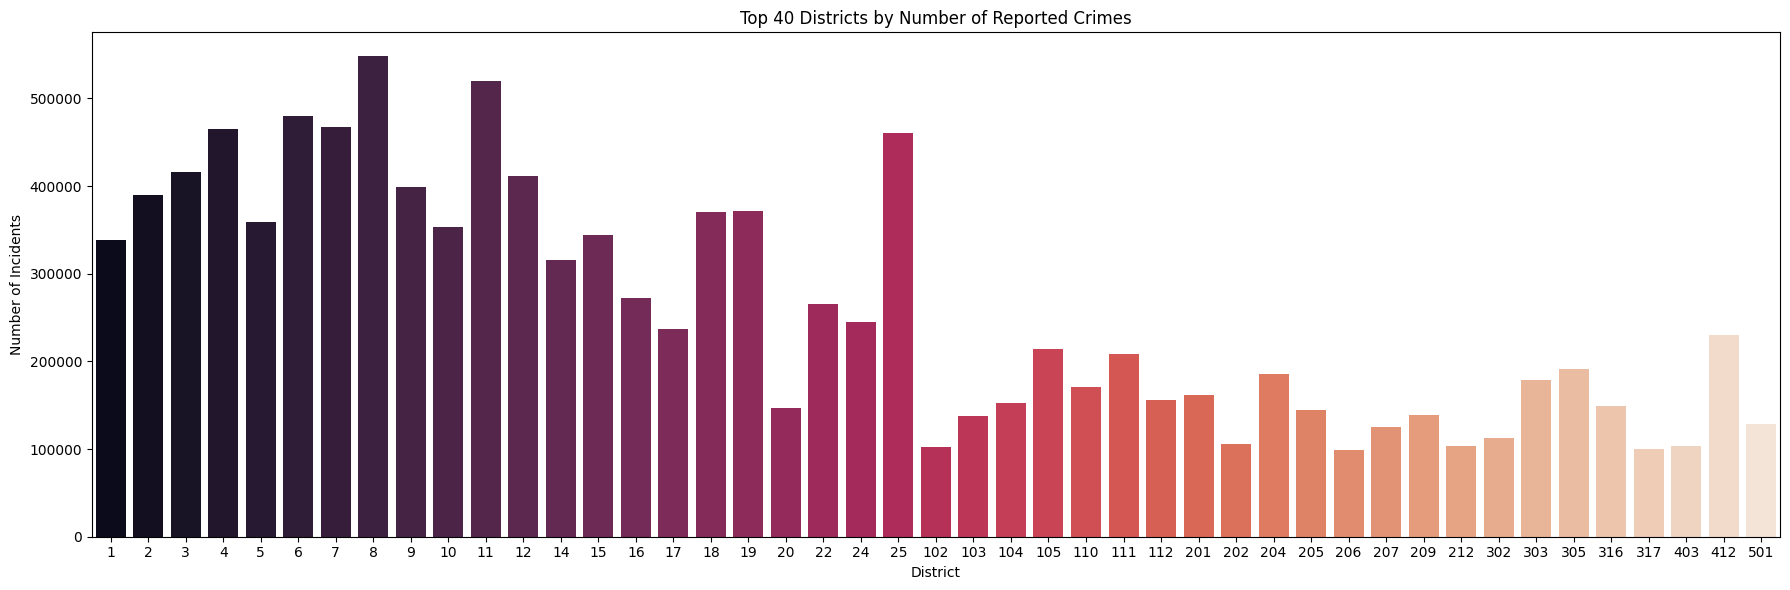

In [29]:
district_counts = gooddf['District'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(18, 6))
sns.barplot(x=district_counts.index[:45], y=district_counts.values[:45], palette='rocket')


plt.title("Top 40 Districts by Number of Reported Crimes")
plt.xlabel("District")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.show()


Year value counts:
 shape: (25, 2)
┌──────┬────────┐
│ year ┆ count  │
│ ---  ┆ ---    │
│ i32  ┆ u32    │
╞══════╪════════╡
│ 2011 ┆ 761020 │
│ 2006 ┆ 816308 │
│ 2010 ┆ 788474 │
│ 2001 ┆ 482823 │
│ 2018 ┆ 509583 │
│ …    ┆ …      │
│ 2009 ┆ 805260 │
│ 2004 ┆ 466059 │
│ 2013 ┆ 699456 │
│ 2003 ┆ 470816 │
│ 2025 ┆ 51827  │
└──────┴────────┘


/var/tmp/ipykernel_22339/278027927.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=gooddf, x='year', palette='viridis')


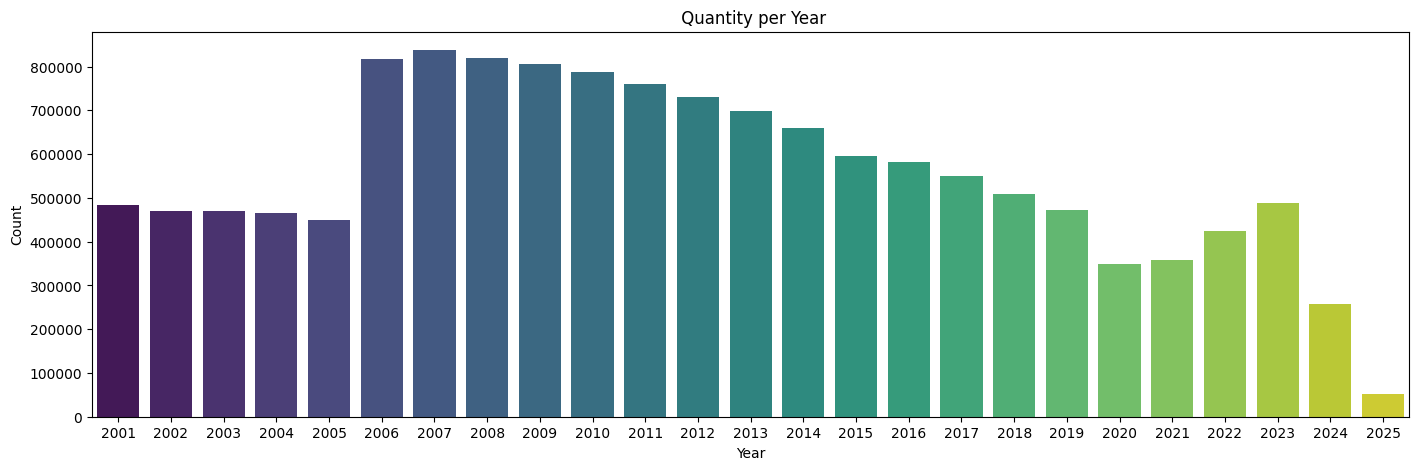

In [35]:
print("Year value counts:\n", df['year'].value_counts())

plt.figure(figsize=(17, 5))
sns.countplot(data=gooddf, x='year', palette='viridis')
plt.title(" Quantity per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

Weekday value counts:
 shape: (7, 2)
┌───────────┬─────────┐
│ Weekday   ┆ count   │
│ ---       ┆ ---     │
│ str       ┆ u32     │
╞═══════════╪═════════╡
│ Wednesday ┆ 2178861 │
│ Sunday    ┆ 1668760 │
│ Thursday  ┆ 2120521 │
│ Friday    ┆ 2137362 │
│ Monday    ┆ 1778870 │
│ Saturday  ┆ 1940243 │
│ Tuesday   ┆ 2070267 │
└───────────┴─────────┘


/var/tmp/ipykernel_22339/3661969841.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=gooddf, x='Weekday', palette='viridis')


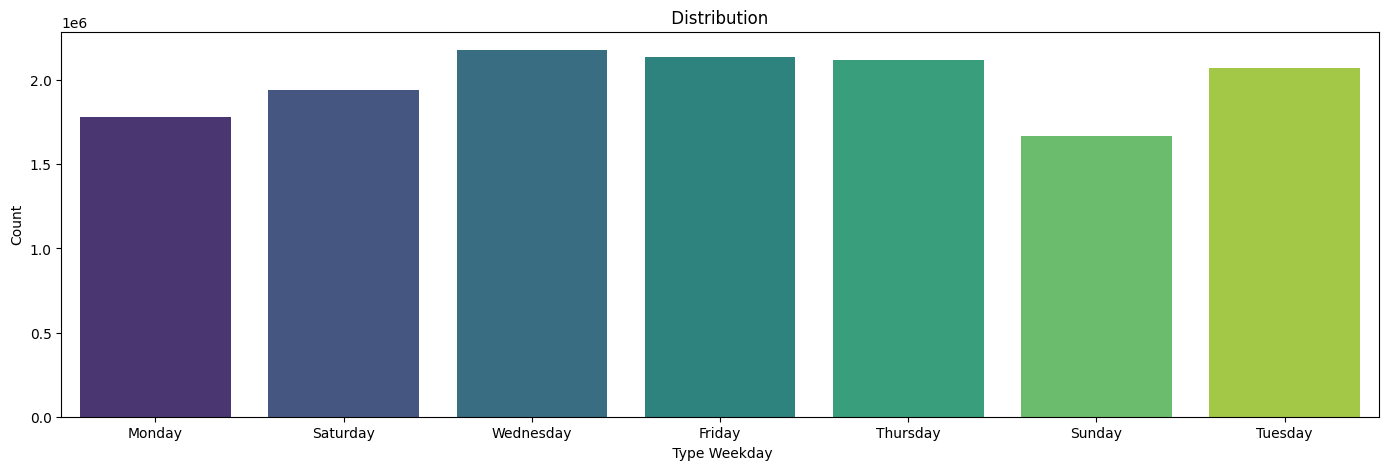

In [33]:
print("Weekday value counts:\n", df['Weekday'].value_counts())

plt.figure(figsize=(17, 5))
sns.countplot(data=gooddf, x='Weekday', palette='viridis')
plt.title(" Distribution ")
plt.xlabel(" Type Weekday")
plt.ylabel("Count")
plt.show()

Race value counts:
 shape: (9, 2)
┌────────────────────────────────┬─────────┐
│ race                           ┆ count   │
│ ---                            ┆ ---     │
│ str                            ┆ u32     │
╞════════════════════════════════╪═════════╡
│ AMERICAN INDIAN/ALASKAN NATIVE ┆ 13069   │
│                                ┆ 8177168 │
│ WHITE                          ┆ 677868  │
│ OTHER                          ┆ 1363    │
│ ASIAN / PACIFIC ISLANDER       ┆ 243441  │
│ BLACK                          ┆ 2779397 │
│ BLACK HISPANIC                 ┆ 468079  │
│ WHITE HISPANIC                 ┆ 1479632 │
│ UNKNOWN                        ┆ 54867   │
└────────────────────────────────┴─────────┘


/var/tmp/ipykernel_22339/2241318999.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=gooddf, x='race', palette='viridis')


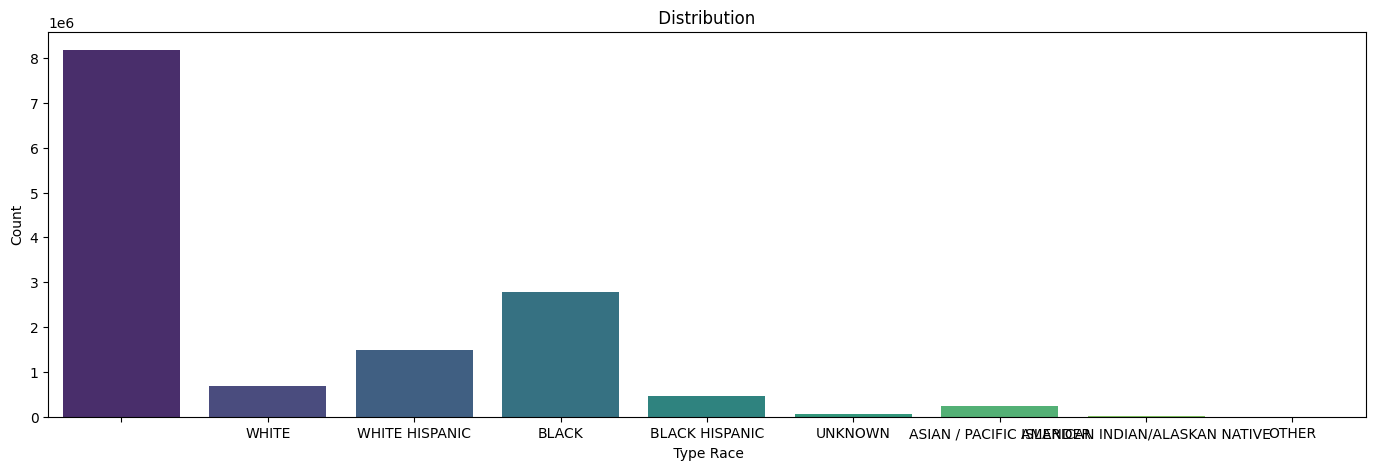

In [32]:
print("Race value counts:\n", df['race'].value_counts())

plt.figure(figsize=(17, 5))
sns.countplot(data=gooddf, x='race', palette='viridis')
plt.title(" Distribution ")
plt.xlabel(" Type Race")
plt.ylabel("Count")
plt.show()

Sexx value counts:
 shape: (4, 2)
┌─────┬─────────┐
│ sex ┆ count   │
│ --- ┆ ---     │
│ str ┆ u32     │
╞═════╪═════════╡
│ M   ┆ 4751004 │
│ F   ┆ 963209  │
│ U   ┆ 3503    │
│     ┆ 8177168 │
└─────┴─────────┘


/var/tmp/ipykernel_22339/1340833187.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=gooddf, x='sex', palette='viridis')


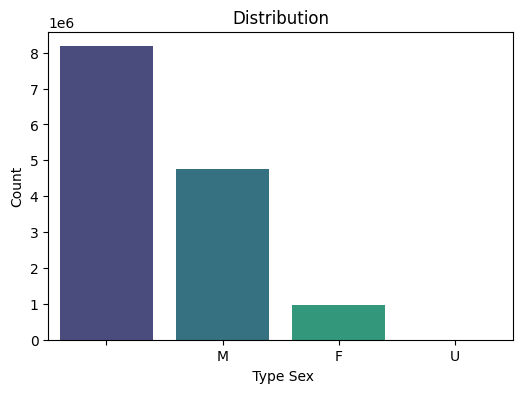

In [31]:
print("Sexx value counts:\n", df['sex'].value_counts())


plt.figure(figsize=(6, 4))
sns.countplot(data=gooddf, x='sex', palette='viridis')
plt.title("Distribution")
plt.xlabel(" Type Sex")
plt.ylabel("Count")
plt.show()

Arrest value counts:
 Arrest
False    11816536
True      2078348
Name: count, dtype: int64


/var/tmp/ipykernel_84808/3488770950.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Arrest', palette='viridis')


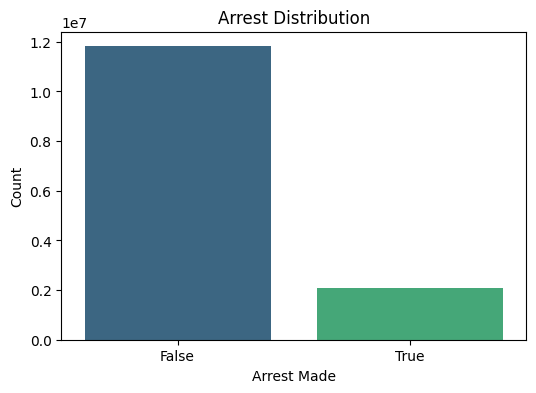

In [ ]:
print("Arrest value counts:\n", df['Arrest'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(data=gooddf, x='Arrest', palette='viridis')
plt.title("Arrest Distribution")
plt.xlabel("Arrest Made")
plt.ylabel("Count")
plt.show()

/var/tmp/ipykernel_6691/1896242097.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=arrest_counts.index[:25], y=arrest_counts.values[:25], palette='viridis')


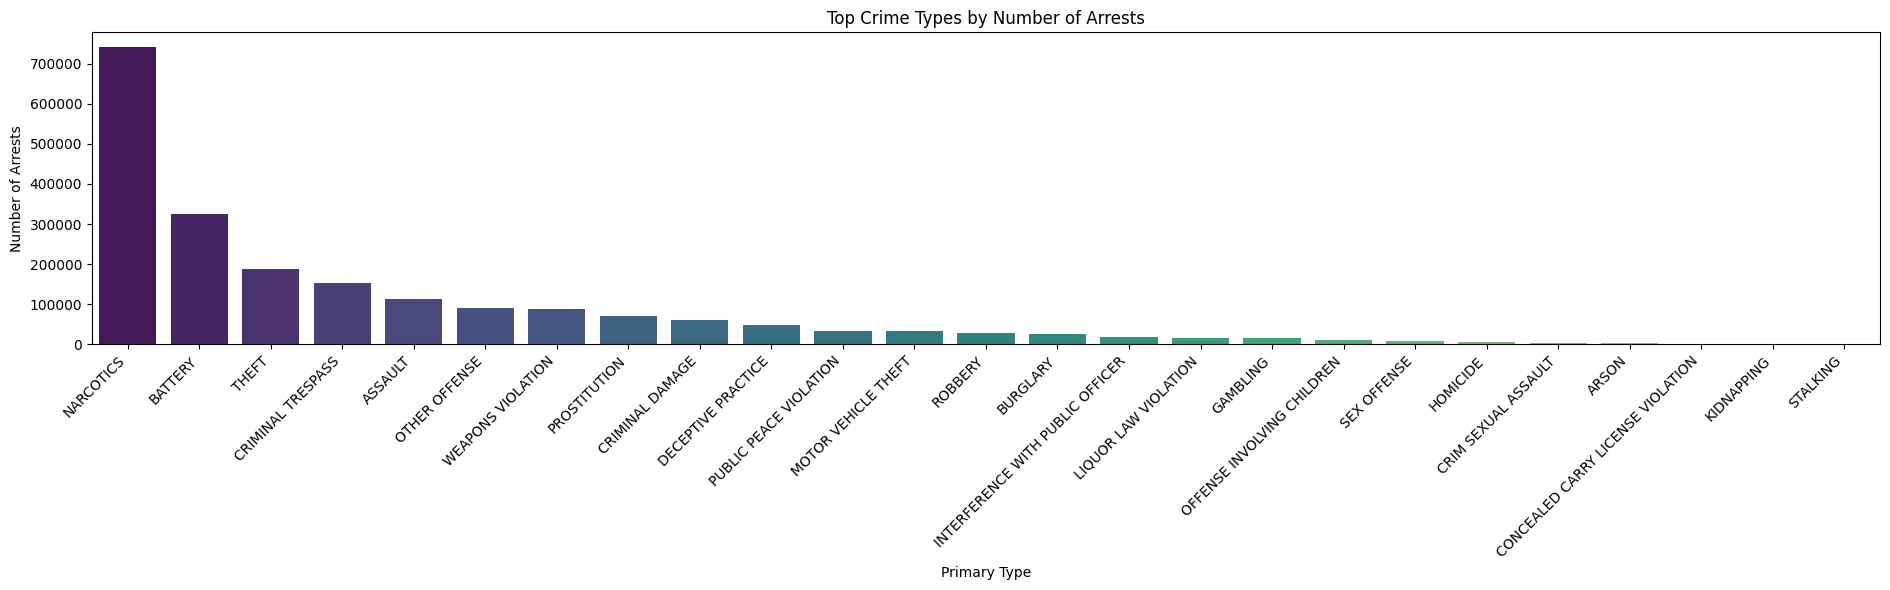

In [14]:
arrest_counts = df[df['arrest'] == True]['primary_type'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(19, 6))
sns.barplot(x=arrest_counts.index[:25], y=arrest_counts.values[:25], palette='viridis')
plt.title("Top Crime Types by Number of Arrests")
plt.ylabel("Number of Arrests")
plt.xlabel("Primary Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/tmp/ipykernel_6691/3951483774.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=crime_counts.index[:25], y=crime_counts.values[:25], palette='mako')


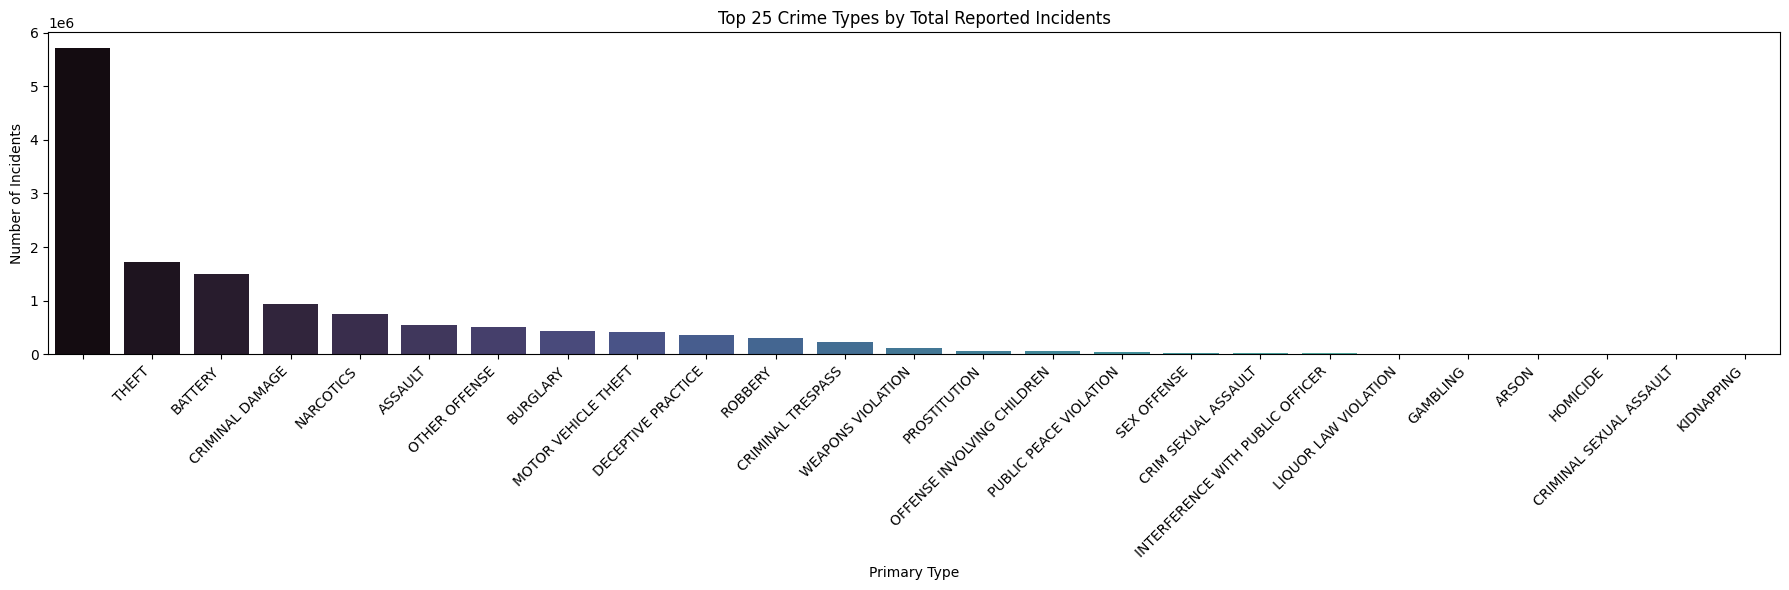

In [19]:
crime_counts = df['primary_type'].value_counts()
plt.figure(figsize=(18, 6))
ax = sns.barplot(x=crime_counts.index[:25], y=crime_counts.values[:25], palette='mako')
plt.title("Top 25 Crime Types by Total Reported Incidents")
plt.ylabel("Number of Incidents")
plt.xlabel("Primary Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [63]:
df['primary_type'].value_counts()

primary_type
                                     5717716
THEFT                                1728866
BATTERY                              1501400
CRIMINAL DAMAGE                       936287
NARCOTICS                             746001
ASSAULT                               548213
OTHER OFFENSE                         510418
BURGLARY                              437143
MOTOR VEHICLE THEFT                   416923
DECEPTIVE PRACTICE                    356863
ROBBERY                               308824
CRIMINAL TRESPASS                     222266
WEAPONS VIOLATION                     121040
PROSTITUTION                           69520
OFFENSE INVOLVING CHILDREN             55028
PUBLIC PEACE VIOLATION                 53829
SEX OFFENSE                            31322
CRIM SEXUAL ASSAULT                    25827
INTERFERENCE WITH PUBLIC OFFICER       19613
LIQUOR LAW VIOLATION                   15113
GAMBLING                               14544
ARSON                                  140

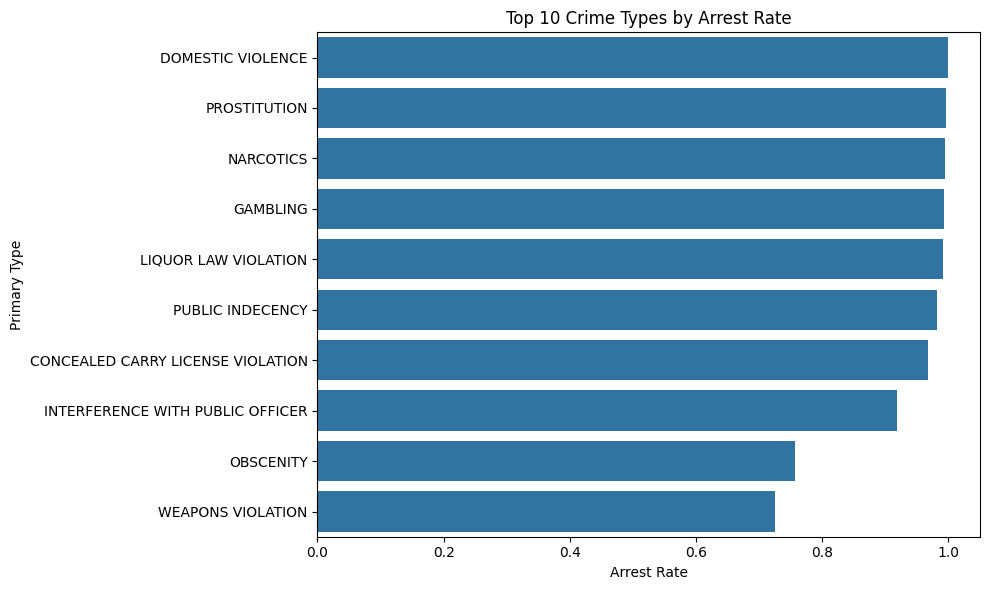

In [36]:
arrest_rates = (
    gooddf.groupby("Primary Type")["Arrest"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=arrest_rates.values, y=arrest_rates.index)
plt.title("Top 10 Crime Types by Arrest Rate")
plt.xlabel("Arrest Rate")
plt.tight_layout()
plt.show()


In [8]:
df["primary type"].value_counts()

primary type
                                     6197716
THEFT                                1728866
BATTERY                              1501400
CRIMINAL DAMAGE                       936287
NARCOTICS                             746001
ASSAULT                               548213
OTHER OFFENSE                         510418
BURGLARY                              437143
MOTOR VEHICLE THEFT                   416923
DECEPTIVE PRACTICE                    356863
ROBBERY                               308824
CRIMINAL TRESPASS                     222266
WEAPONS VIOLATION                     121040
PROSTITUTION                           69520
OFFENSE INVOLVING CHILDREN             55028
PUBLIC PEACE VIOLATION                 53829
SEX OFFENSE                            31322
CRIM SEXUAL ASSAULT                    25827
INTERFERENCE WITH PUBLIC OFFICER       19613
LIQUOR LAW VIOLATION                   15113
GAMBLING                               14544
ARSON                                  140

In [ ]:
def count_missing(df):
    return (
        df.isnull().sum() +                    
        df.apply(lambda col: col.astype(str).str.strip().eq('').sum()) 
    )

missing_counts = count_missing(df)
missing_counts[missing_counts > 0]

age                     8177185
arrest_boro             8177177
block                   6197716
case number             6197716
description                9577
district                6197763
fbi code                6197716
iucr                    6197716
law_cat_cd              8201984
law_code                8177369
location                6197716
location description    6206836
lon_lat                 8177168
pd_desc                 8186745
primary type            6197716
race                    8177168
sex                     8177168
updated on              6197716
dtype: int64

In [33]:
unique_values = df.nunique()
unique_values

Id                      13804624
Date                     3434055
PD_CD                        344
PD_DESC                      443
KY_CD                         77
Description                  658
LAW_CODE                    2549
LAW_CAT_CD                     7
ARREST_BORO                    6
ARREST_PRECINCT               78
JURISDICTION_CODE             30
age                           92
sex                            4
race                           9
X Coordinate              151069
Y Coordinate              206535
Latitude                 1072458
Longitude                1072413
Lon_Lat                   180402
geom                     1083673
District                      96
Case Number              8176579
Block                      63183
IUCR                         422
Primary Type                  37
Location Description         219
Arrest                         2
Domestic                       2
Beat                         305
Ward                          51
Community 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14374884 entries, 0 to 14374883
Data columns (total 37 columns):
 #   Column                Dtype  
---  ------                -----  
 0   age                   string 
 1   arrest                bool   
 2   arrest_boro           string 
 3   arrest_precinct       int32  
 4   beat                  int32  
 5   block                 string 
 6   case number           string 
 7   community area        int32  
 8   date                  string 
 9   description           string 
 10  dist_num              int32  
 11  district              string 
 12  domestic              bool   
 13  fbi code              string 
 14  geom                  string 
 15  id                    int32  
 16  intersects            bool   
 17  iucr                  string 
 18  jurisdiction_code     int32  
 19  ky_cd                 int32  
 20  latitude              float64
 21  law_cat_cd            string 
 22  law_code              string 
 23  locat

In [4]:
df.columns

Index(['age', 'arrest', 'arrest_boro', 'arrest_precinct', 'beat', 'block',
       'case number', 'community area', 'date', 'description', 'dist_num',
       'district', 'domestic', 'fbi code', 'geom', 'id', 'intersects', 'iucr',
       'jurisdiction_code', 'ky_cd', 'latitude', 'law_cat_cd', 'law_code',
       'location', 'location description', 'lon_lat', 'longitude', 'pd_cd',
       'pd_desc', 'primary type', 'race', 'sex', 'updated on', 'ward',
       'x coordinate', 'y coordinate', 'year'],
      dtype='object')

In [3]:
df['jurisdiction_code'].isnull().sum()

np.int64(0)

In [7]:
df.isnull().sum()


age                     0
arrest                  0
arrest_boro             0
arrest_precinct         0
beat                    0
block                   0
case number             0
community area          0
date                    0
description             0
dist_num                0
district                0
domestic                0
fbi code                0
geom                    0
id                      0
intersects              0
iucr                    0
jurisdiction_code       0
ky_cd                   0
latitude                0
law_cat_cd              0
law_code                0
location                0
location description    0
lon_lat                 0
longitude               0
pd_cd                   0
pd_desc                 0
primary type            0
race                    0
sex                     0
updated on              0
ward                    0
x coordinate            0
y coordinate            0
year                    0
dtype: int64

In [11]:
df["district"].value_counts()

district
      6197763
8      547988
11     519731
6      480170
7      467007
4      465179
25     460787
3      416115
12     411158
9      398745
2      389377
19     372072
18     370478
5      359199
10     352755
15     344455
1      338625
14     316023
16     272439
22     265092
24     245239
17     237421
20     146902
31        160
21          4
Name: count, dtype: Int64

In [10]:
df.isnull().sum()

age                     0
arrest                  0
arrest_boro             0
arrest_precinct         0
beat                    0
block                   0
case number             0
community area          0
date                    0
description             0
dist_num                0
district                0
domestic                0
fbi code                0
geom                    0
id                      0
intersects              0
iucr                    0
jurisdiction_code       0
ky_cd                   0
latitude                0
law_cat_cd              0
law_code                0
location                0
location description    0
lon_lat                 0
longitude               0
pd_cd                   0
pd_desc                 0
primary type            0
race                    0
sex                     0
updated on              0
ward                    0
x coordinate            0
y coordinate            0
year                    0
dtype: int64